In [1]:
# pip install SpeechRecognition --quiet
# !pip3 install pyaudio 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as TTS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics.pairwise import cosine_similarity
import random

import nltk
import re
from sklearn.svm import SVC
from nltk.stem.lancaster import LancasterStemmer
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HIMANGSHUB\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data reading

In [3]:
chatbot_df = pd.read_csv("Cleaned Dataset\\final-dataset.csv")
chatbot_df.head()

,Question,Answer,Intent
0,what does it mean to have a mental illness,Mental illnesses are health conditions that di...,mental_health
1,who does mental illness affect,It is estimated that mental illness affects 1 ...,mental_health
2,what causes mental illness,It is estimated that mental illness affects 1 ...,mental_health
3,what are some of the warning signs of mental i...,Symptoms of mental health disorders vary depen...,mental_health
4,can people with mental illness recover,"When healing from mental illness, early identi...",mental_health


## Function for the stemming the data

In [4]:
stemmer = LancasterStemmer()

In [5]:
def cleanup(sentence):
    sentence = sentence.lower()
    word_tok = nltk.word_tokenize(sentence)
    stemmed_words = [stemmer.stem(w) for w in word_tok]
    return ' '.join(stemmed_words)

In [6]:
sentence = "Q: symptoms 6 of heart attack ?"
cleanup(sentence)

'q : symptom 6 of heart attack ?'

## tfidf and label encoding and stemming data

In [7]:
tfv = TfidfVectorizer(min_df=1)
label_encode = LE()

In [8]:
input_data = chatbot_df["Question"]
output_data = chatbot_df["Intent"]

In [9]:
stemmed_input_data = []
for question in input_data:
    stemmed_input_data.append(cleanup(question))

In [10]:
tfv.fit(stemmed_input_data)
label_encode.fit(output_data)

input_vec = tfv.transform(stemmed_input_data)
output_le = label_encode.transform(output_data)

In [11]:
print(type(input_vec))
print(input_vec.shape)

<class 'scipy.sparse._csr.csr_matrix'>
(721, 1110)


### Spliting the data 

In [12]:
x_train,x_test,y_train,y_test = TTS(input_vec,output_le, test_size = .30 , random_state=30)

## Model implementation - SVM

In [13]:
model_linear = SVC(kernel='linear')
model_linear.fit(x_train, y_train)

SVC(kernel='linear')

In [14]:
# predicted value for the test data
y_pred = model_linear.predict(x_test)


accuracy score: 86.635945
[[55  1  0  0  0  0  2]
 [ 1 32  1  1  0  0  2]
 [ 4  0 22  0  1  0  0]
 [ 2  0  0  1  0  1  0]
 [ 3  1  0  0 36  0  0]
 [ 1  0  0  0  1 18  0]
 [ 2  1  1  0  1  2 24]]


Text(0.5, 1.0, 'Confusion matrix')

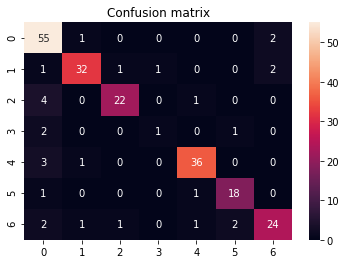

In [15]:
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score,confusion_matrix
print("\naccuracy score: %f"%(accuracy_score(y_test,y_pred)*100))
print(confusion_matrix(y_test,y_pred))
sns.heatmap(data=confusion_matrix(y_test,y_pred),annot=True)
plt.title("Confusion matrix")

In [16]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 5)
 
# fitting the model for grid search
grid.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.277 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.277 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.287 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.277 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.280 total time=   0.0s
[CV 1/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.277 total time=   0.0s
[CV 2/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.277 total time=   0.0s
[CV 3/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.287 total time=   0.0s
[CV 4/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.277 total time=   0.0s
[CV 5/5] END .......C=0.1, gamma=1, kernel=poly;, score=0.280 total time=   0.0s
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.277 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rb

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=5)

In [17]:
grid.best_estimator_

SVC(C=100, gamma=0.1)

In [18]:
grid.best_params_

{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

In [19]:
model = SVC( kernel='rbf' , C=100 , gamma=0.1)
model.fit(x_train,y_train);

In [20]:
y_pred_cv = model.predict(x_test)


accuracy score: 87.096774
[[55  1  0  0  0  1  1]
 [ 1 34  0  1  0  0  1]
 [ 3  0 22  0  1  0  1]
 [ 2  0  0  1  0  1  0]
 [ 3  1  0  0 36  0  0]
 [ 1  0  0  0  1 18  0]
 [ 2  2  1  0  1  2 23]]


Text(0.5, 1.0, 'Confusion matrix')

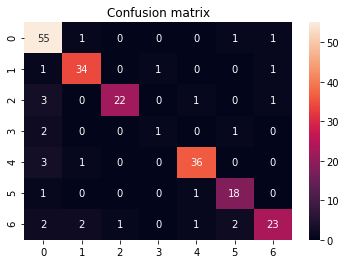

In [21]:
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score,confusion_matrix
print("\naccuracy score: %f"%(accuracy_score(y_test,y_pred_cv)*100))
print(confusion_matrix(y_test,y_pred_cv))
sns.heatmap(data=confusion_matrix(y_test,y_pred_cv),annot=True)
plt.title("Confusion matrix")

## MODEL WITH KNN CLASSIFIER

In [22]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsClassifier()

In [23]:
y_pred_knn = knn.predict(x_test)

c:\Users\HIMANGSHUB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:211: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)



accuracy score: 78.801843
[[56  0  0  0  0  2  0]
 [ 3 30  0  1  2  0  1]
 [ 2  4 17  2  2  0  0]
 [ 2  1  0  1  0  0  0]
 [ 4  1  1  1 33  0  0]
 [ 2  1  0  0  0 17  0]
 [ 3  6  2  1  0  2 17]]


Text(0.5, 1.0, 'Confusion matrix')

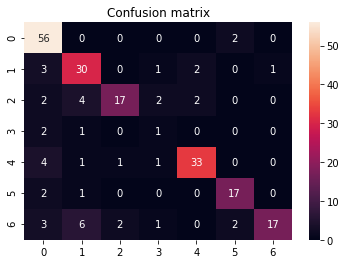

In [24]:
from sklearn.metrics import accuracy_score,recall_score,roc_auc_score,confusion_matrix
print("\naccuracy score: %f"%(accuracy_score(y_test,y_pred_knn)*100))
print(confusion_matrix(y_test,y_pred_knn))
sns.heatmap(data=confusion_matrix(y_test,y_pred_knn),annot=True)
plt.title("Confusion matrix")

## Testing new query 

In [25]:
query = "sympto  attack"
stemmed_query = cleanup(query.strip())
query_vec = tfv.transform([stemmed_query])
pre = model.predict(query_vec)[0]
intent = label_encode.inverse_transform([pre])
intent

array(['heart'], dtype=object)

In [26]:
question_set = chatbot_df[ chatbot_df['Intent']==intent[0]]

## Apply Cosine Similarity to get the appropriate Answer

In [27]:
cos_sims = []
for question in question_set['Question']:
    sims = cosine_similarity(tfv.transform([cleanup(question.strip())]), query_vec)
    cos_sims.append(sims)

In [28]:
most_similar_question_index = cos_sims.index(max(cos_sims))

## output

In [29]:
# most similar question index 
question_set.iloc[most_similar_question_index]

Question                               treating heart attacks
Answer      Treating heart attacksWhile waiting for an amb...
Intent                                                  heart
Name: 572, dtype: object

## Function to get the top 5 Possible questions

In [30]:
def top_5_similar_qns(cos_sim_array):
    indx = []
    for ind , score in enumerate(cos_sim_array):
        indx.append([score[0][0] , ind])
    indx.sort(reverse=True)
    return indx[:5]
top_5_similar_qns(cos_sims)

[[0.6401609369318505, 1],
 [0.6007619935149432, 2],
 [0.5869432180201272, 0],
 [0.5615951742855108, 4],
 [0.5473767072400423, 123]]

## Response to not found any match

In [31]:
def not_found():
    print("Medicus: Sorry, I could not understand you question!")

## Function for Chat 

In [32]:
def ChatMatch(query):
    # clean the query
    query = cleanup(query.strip())
    # vectorized the query
    query_vec = tfv.transform([query])
    # predict the intent 
    pred = model.predict(query_vec)[0]
    intent = label_encode.inverse_transform([pred])
    # find the question set based on the intent classified 
    question_set = chatbot_df[ chatbot_df['Intent']==intent[0]]
    # apply cosine similarity to get the top 5 similar match
    cos_sims = []
    for question in question_set['Question']:
        sims = cosine_similarity(tfv.transform([question]), query_vec)
        cos_sims.append(sims)
    # top 5 questions with index and scores
    top_5_match = top_5_similar_qns(cos_sims)
    if(top_5_match[0][0]>=0.40):
        max_score_idx = top_5_match[0][1]
        print(f"Medicus: Your query : {question_set.iloc[max_score_idx].Question}")
        print(f"Medicus: {question_set.iloc[max_score_idx].Answer}")
        index = int(input(f"Medicus: Was this answer helpful? \n 1.Yes \n 2.No"))
        if(index==1):
            print("Medicus: Thank you.. Happy Reading !")
        else:
            print("Medicus: Hope the following helps :")
            print("Top five query based ob your search :")
            for idx in range(5):
                print(f"{idx+1}. {question_set.iloc[top_5_match[idx][1]].Question}")
            print("6. Not found")
            res = int(input("Select the questions Number.."))
            if(res==6):
                not_found()
            else:
                print(f"Medicus: Your query : {question_set.iloc[top_5_match[res-1][1]].Question}")
                print(f"Medicus: {question_set.iloc[top_5_match[res-1][1]].Answer}" )
    else:
        not_found()
    

## CHATBOT STARTS

In [33]:
# get query through voice
def getVoiceText():
    import speech_recognition as sr
    SR = sr.Recognizer()
    with sr.Microphone() as source:
        print("Speak Anything!...I am Listening.... :")
        audio = SR.listen(source)
        try:
            text = SR.recognize_google(audio)
            return text
        except:
            return "0"

In [34]:
print("Medicus: Welcome to my world!")
chat = True 

while chat:
    query = input("Medicus: HELLO, Asked me anything about disease!")
    if query.lower() == 'bye':
        print("Medicus: Good Bye, Hope to see you again !")
        chat = False
    elif query:
        ChatMatch(query)
    else:
        chat == False

## chatbot with voice installed

In [35]:
# print("Medicus: Welcome to my world!")
# chat = True 

# while chat:
#     query = getVoiceText()
#     print(f"Your query : {query}")
#     if(query =='0'):
#         not_found()
#     elif query.lower() == 'bye':
#         print("Medicus: Good Bye, Hope to see you again !")
#         chat = False
#     elif query:
#         ChatMatch(query)
#     else:
#         chat == False

## Build model with Lemmatized data

In [36]:
# chatbot_df_lem = pd.read_csv("Cleaned Dataset\lemmatized-data.csv")
# input_data_lem = chatbot_df_lem["Question"]
# output_data_lem = chatbot_df_lem["Intent"]
# tfv.fit(input_data_lem)
# label_encode.fit(output_data_lem)
# input_vec_lem = tfv.transform(input_data_lem)
# output_le_lem = label_encode.transform(output_data_lem)
# x_train_lem,x_test_lem,y_train_lem,y_test_lem = TTS(input_vec_lem,output_le_lem, test_size = .30 , random_state=30)
# model_lem = SVC(kernel='linear')
# model_lem.fit(x_train_lem, y_train_lem)
# print("SVC Score:", model_lem.score(x_test_lem, y_test_lem))


## Export Model

In [37]:
import pickle

In [38]:
pickle.dump(model, open('__website/pickles/model.pkl','wb'))

In [39]:
pickle.dump(tfv , open('__website/pickles/tfidf.pkl','wb'))

In [40]:
pickle.dump(label_encode , open('__website/pickles/le.pkl','wb'))